In [1]:
import os
import re
import json
import logging
import asyncio
import numpy as np
import pandas as pd
from groq import Groq
from dotenv import load_dotenv
from dataclasses import dataclass
from langchain_groq import ChatGroq
from datetime import date, datetime
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, List, Tuple, Optional, Any
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import Graph, StateGraph, END, START
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
import re

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
load_dotenv()

True

In [3]:
# Configure LLM (adjust model name as needed)
llm = ChatGroq(
    model="gemma2-9b-it",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [4]:
class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description="Column name for transaction date")
    debit: str = Field(..., description="Column name for debit amount")
    credit: str = Field(..., description="Column name for credit amount")


class BankReconciliationState(BaseModel):
    bank_data: str
    erp_data: str
    bank_columns: Optional[ColumnSchema] = None
    erp_columns: Optional[ColumnSchema] = None
    bank_chunk_data: List[pd.DataFrame] = Field(default_factory=list)
    erp_chunk_data: List[pd.DataFrame] = Field(default_factory=list)
    erp_chunk_amount: Optional[float] = 0
    bank_chunk_amount: Optional[float] = 0
    erp_total_amount: Optional[float] = 0
    bank_total_amount: Optional[float] = 0
    messages: Optional[str] = None
    index: Optional[int] = 0

    model_config = {
        "arbitrary_types_allowed": True
    }

In [5]:
# Create structured output wrapper if desired (keeps original name)
structured_model_column = llm.with_structured_output(ColumnSchema)

In [6]:
# Reusable function for detecting columns
def detect_columns(file_path: str):
    df = pd.read_csv(file_path)
    subset_data = df.head(5)
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """
    return structured_model_column.invoke(prompt)

# Node: find columns in bank dataset
def find_bank_columns(state: BankReconciliationState):
    result = detect_columns(state.bank_data)
    # return as dict (langgraph expects dict)
    print(result)
    return {"bank_columns": result}

# Node: find columns in ERP dataset
def find_erp_columns(state: BankReconciliationState):
    result = detect_columns(state.erp_data)
    print(result)
    return {"erp_columns": result}

In [7]:
def chunk_dataset(state: BankReconciliationState):
    """
    Split both datasets into chunks of up to 3 days each.
    Keep only 'transaction_date', 'debit', 'credit' columns in state data.
    """

    bank_date_column = state.bank_columns.transaction_date
    erp_date_column = state.erp_columns.transaction_date

    # Load datasets
    bank_df = pd.read_csv(state.bank_data)
    erp_df = pd.read_csv(state.erp_data)

    # Ensure transaction_date is datetime
    bank_df[bank_date_column] = pd.to_datetime(bank_df[bank_date_column], errors="coerce")
    erp_df[erp_date_column] = pd.to_datetime(erp_df[erp_date_column], errors="coerce")

    # Drop invalid dates
    bank_df = bank_df.dropna(subset=[bank_date_column])
    erp_df = erp_df.dropna(subset=[erp_date_column])

    # Helper function to chunk by 3-day windows
    def split_by_days(df, date_column):
        if df.empty:
            return []
        df = df.sort_values(by=date_column).reset_index(drop=True)
        min_date, max_date = df[date_column].min(), df[date_column].max()

        if (max_date - min_date).days < 2:
            return [df]

        chunks = []
        start_date = min_date
        while start_date <= max_date:
            end_date = start_date + pd.Timedelta(days=1)
            chunk = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
            if not chunk.empty:
                chunks.append(chunk.reset_index(drop=True))
            start_date = end_date + pd.Timedelta(days=1)
        return chunks

    # Split datasets
    bank_chunks = split_by_days(bank_df, bank_date_column)
    erp_chunks = split_by_days(erp_df, erp_date_column)

    # Ensure both have the same number of chunks (pad smaller with empty DataFrames)
    max_chunks = max(len(bank_chunks), len(erp_chunks))
    while len(bank_chunks) < max_chunks:
        bank_chunks.append(pd.DataFrame(columns=bank_df.columns))
    while len(erp_chunks) < max_chunks:
        erp_chunks.append(pd.DataFrame(columns=erp_df.columns))

    # Keep only required columns in each chunk
    required_bank_cols = [bank_date_column, state.bank_columns.debit, state.bank_columns.credit]
    required_erp_cols = [erp_date_column, state.erp_columns.debit, state.erp_columns.credit]

    state.bank_chunk_data = [chunk[required_bank_cols].copy() for chunk in bank_chunks]
    state.erp_chunk_data = [chunk[required_erp_cols].copy() for chunk in erp_chunks]

    return {
        "bank_chunk_data": state.bank_chunk_data,
        "erp_chunk_data": state.erp_chunk_data
    }

In [8]:
def reconciliations(state: BankReconciliationState):
    import time
    time.sleep(5)
    """LLM-powered reconciliation function that generates Python code for calculations.
    Always return a dict of state updates (not the model object or END constant).
    """
    index = int(state.index or 0)
    print("================================: ", index)
    # Guard for index out of range
    if index >= max(len(state.bank_chunk_data), len(state.erp_chunk_data)):
        # nothing to do
        return {"messages": "END"}

    bank_df = state.bank_chunk_data[index]
    erp_df = state.erp_chunk_data[index]

    # Extract dynamic column names from state
    bank_transaction_date = state.bank_columns.transaction_date
    bank_credit = state.bank_columns.credit
    bank_debit = state.bank_columns.debit
    erp_transaction_date = state.erp_columns.transaction_date
    erp_credit = state.erp_columns.credit
    erp_debit = state.erp_columns.debit

    # Build prompt for LLM
    bank_sample = bank_df.head(5).to_string() if not bank_df.empty else "No data"
    erp_sample = erp_df.head(5).to_string() if not erp_df.empty else "No data"

    prompt = f"""You are a financial analyst. Write Python code to calculate net balance for two datasets.

        Bank dataset columns:
        - Transaction date: "{bank_transaction_date}"
        - Debit: "{bank_debit}" 
        - Credit: "{bank_credit}"

        ERP dataset columns:
        - Transaction date: "{erp_transaction_date}"
        - Debit: "{erp_debit}"
        - Credit: "{erp_credit}"

        Sample bank data:
        {bank_sample}

        Sample ERP data:
        {erp_sample}

        Task: Write Python code to calculate net balance for bank dataset is (total_credit - total_debit) and net balance for erp dataset is (total_debit - total_credit).

        Requirements:
        1. Convert columns to numeric, handling commas and NaN values as 0
        2. Calculate: bank_net_balance = bank_total_credit - bank_total_debit
        3. Calculate: erp_net_balance = erp_total_debit - erp_total_credit 
        4. Use the exact column names provided above
        5. Return only executable Python code, no explanations or markdown

        Example format:
        # Clean bank data
        bank_df['{bank_credit}'] = pd.to_numeric(bank_df['{bank_credit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
        bank_df['{bank_debit}'] = pd.to_numeric(bank_df['{bank_debit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
        bank_total_credit = bank_df['{bank_credit}'].sum()
        bank_total_debit = bank_df['{bank_debit}'].sum()
        bank_net_balance = bank_total_credit - bank_total_debit

        # Clean ERP data
        erp_df['{erp_credit}'] = pd.to_numeric(erp_df['{erp_credit}'], errors='coerce').fillna(0)
        erp_df['{erp_debit}'] = pd.to_numeric(erp_df['{erp_debit}'], errors='coerce').fillna(0)
        erp_total_credit = erp_df['{erp_credit}'].sum()
        erp_total_debit = erp_df['{erp_debit}'].sum()
        erp_net_balance = erp_total_debit - erp_total_credit"""

    try:
        from langchain_core.messages import HumanMessage
        response = llm.invoke([HumanMessage(content=prompt)])
        code = response.content
        code = re.sub(r'```python\n?', '', code)
        code = re.sub(r'\n?```', '', code).strip()

        # Execute code in safe local scope
        local_vars = {"bank_df": bank_df.copy(), "erp_df": erp_df.copy(), "pd": pd}
        exec(code, {"pd": pd}, local_vars)

        bank_net_balance = local_vars.get("bank_net_balance")
        erp_net_balance = local_vars.get("erp_net_balance")

        if bank_net_balance is None or erp_net_balance is None:
            raise ValueError("LLM code did not produce required variables")
        print(f"💰 LLM Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
        # Update state fields via dict
        return {
            "bank_chunk_amount": float(bank_net_balance),
            "erp_chunk_amount": float(erp_net_balance)
        }

    except Exception as e:
        # Fallback hardcoded calculation
        bank_df = bank_df.copy()
        erp_df = erp_df.copy()

        # Safe column conversions (use provided names)
        try:
            bank_df[bank_credit] = pd.to_numeric(bank_df[bank_credit].astype(str).str.replace(',', '', regex=False), errors='coerce').fillna(0)
            bank_df[bank_debit] = pd.to_numeric(bank_df[bank_debit].astype(str).str.replace(',', '', regex=False), errors='coerce').fillna(0)
            bank_total_credit = bank_df[bank_credit].sum()
            bank_total_debit = bank_df[bank_debit].sum()
            bank_net_balance = bank_total_credit - bank_total_debit
        except Exception:
            bank_net_balance = 0.0

        try:
            erp_df[erp_credit] = pd.to_numeric(erp_df[erp_credit], errors='coerce').fillna(0)
            erp_df[erp_debit] = pd.to_numeric(erp_df[erp_debit], errors='coerce').fillna(0)
            erp_total_credit = erp_df[erp_credit].sum()
            erp_total_debit = erp_df[erp_debit].sum()
            erp_net_balance = erp_total_debit - erp_total_credit
        except Exception:
            erp_net_balance = 0.0
        print(f"💰 Fallback Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
    
        return {
            "bank_chunk_amount": float(bank_net_balance),
            "erp_chunk_amount": float(erp_net_balance)
        }

print("✅ Helper functions defined")

✅ Helper functions defined


In [9]:
def compare_chunk_balances(state: BankReconciliationState):
    """
    Compare the latest Bank and ERP chunk balances.
    Always return a dict of updates.
    """
    try:
        bank_val = float(state.bank_chunk_amount or 0)
        erp_val = float(state.erp_chunk_amount or 0)
        index = int(state.index or 0)

        if bank_val == erp_val:
            print("Bank_total_amount: ", float((state.bank_total_amount or 0) + bank_val),"\n", "Erp_total_amount: ", float((state.erp_total_amount or 0) + erp_val))
            # add to totals and advance
            return {
                "bank_total_amount": float((state.bank_total_amount or 0) + bank_val),
                "erp_total_amount": float((state.erp_total_amount or 0) + erp_val),
                "bank_chunk_amount": 0.0,
                "erp_chunk_amount": 0.0,
                "index": index + 1,
                "messages": "reconciliations"
            }
        else:
            return {"messages": "eliminate_and_subtrct_values"}
    except Exception as e:
        return {"error": str(e)}

In [10]:
# Clean data helper
def clean_dataframe(df, debit_col, credit_col):
    df = df.copy()
    df[debit_col] = df[debit_col].fillna(0)
    df[credit_col] = df[credit_col].fillna(0)

    def clean_numeric(series):
        return (
            series.astype(str)
            .str.replace(",", "", regex=True)
            .str.replace(" ", "", regex=True)
            .str.strip()
            .replace("", "0")
            .astype(float)
        )

    df[debit_col] = clean_numeric(df[debit_col])
    df[credit_col] = clean_numeric(df[credit_col])
    return df

In [11]:
def normalize_columns(df: pd.DataFrame):
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
    return df


In [12]:
def eliminate_and_subtrct_values(state: BankReconciliationState):
    index = int(state.index or 0)
    bank_df = state.bank_chunk_data[index]
    erp_df = state.erp_chunk_data[index]

    bank_credit = state.bank_columns.credit
    bank_debit = state.bank_columns.debit
    erp_credit = state.erp_columns.credit
    erp_debit = state.erp_columns.debit

    if bank_df is None or erp_df is None:
        return {"messages": "END"}

    bank_df = clean_dataframe(bank_df, bank_debit, bank_credit)
    erp_df = clean_dataframe(erp_df, erp_debit, erp_credit)

    erp_chunk_amount = (
        float(state.erp_chunk_amount or 0)
        - (bank_df[bank_debit].sum() if not bank_df.empty else 0)
        + (bank_df[bank_credit].sum() if not bank_df.empty else 0)
    )

    bank_chunk_amount = (
        float(state.bank_chunk_amount or 0)
        - (erp_df[erp_credit].sum() if not erp_df.empty else 0)
        + (erp_df[erp_debit].sum() if not erp_df.empty else 0)
    )

    print("✅ Updated balances:\nERP:", state.erp_chunk_amount, "\nBank:", state.bank_chunk_amount)
    print("Bank_total_amount: ", float((state.bank_total_amount or 0) + bank_chunk_amount),"\n", "Erp_total_amount: ", float((state.erp_total_amount or 0) + erp_chunk_amount))
    # Return updates as dict and advance index
    return {
        "bank_total_amount": float((state.bank_total_amount or 0) + bank_chunk_amount),
        "erp_total_amount": float((state.erp_total_amount or 0) + erp_chunk_amount),
        "bank_chunk_amount": 0.0,
        "erp_chunk_amount": 0.0,
        "index": index + 1,
        "messages": "reconciliations"
    }


In [13]:
# Conditional edges
def route_after_comparison(state: BankReconciliationState):
    messages = state.messages or ""
    if isinstance(messages, str) and "eliminate_and_subtrct_values" in messages:
        return "eliminate_and_subtrct_values"
    elif isinstance(messages, str) and "reconciliations" in messages:
        return "reconciliations"
    else:
        return END

In [14]:
# chunk_length_check should return a dict
def chunk_length_check(state: BankReconciliationState):
    index_number = int(state.index or 0)
    chunk_length = max(len(state.bank_chunk_data), len(state.erp_chunk_data))
    print(chunk_length)
    if index_number < chunk_length:
        return {"messages": "reconciliations"}
    else:
        # signal termination via a message value; return dict not END constant
        return {"messages": "END"}

In [15]:
# route for chunk_length_check
def route_length_check(state: BankReconciliationState):
    messages = state.messages or ""
    if isinstance(messages, str) and "reconciliations" in messages:
        return "reconciliations"
    else:
        return END

In [16]:
# --- Build workflow ---
graph = StateGraph(BankReconciliationState)

# Add nodes
graph.add_node("find_bank_columns", find_bank_columns)
graph.add_node("find_erp_columns", find_erp_columns)
graph.add_node("chunk_dataset", chunk_dataset)
graph.add_node("reconciliations", reconciliations)
graph.add_node("compare_chunk_balances", compare_chunk_balances)
graph.add_node("eliminate_and_subtrct_values", eliminate_and_subtrct_values)
graph.add_node("chunk_length_check", chunk_length_check)

# Connect edges
graph.add_edge(START, "find_bank_columns")
graph.add_edge(START, "find_erp_columns")
graph.add_edge("find_bank_columns", "chunk_dataset")
graph.add_edge("find_erp_columns", "chunk_dataset")
graph.add_edge("chunk_dataset", "reconciliations")
graph.add_edge("reconciliations", "compare_chunk_balances")

graph.add_conditional_edges(
    "compare_chunk_balances",
    route_after_comparison,
    {
        "reconciliations": "reconciliations",
        "eliminate_and_subtrct_values": "eliminate_and_subtrct_values",
        END: END
    }
)

graph.add_edge("eliminate_and_subtrct_values", "chunk_length_check")
graph.add_conditional_edges(
    "chunk_length_check",
    route_length_check,
    {
        "reconciliations": "reconciliations",
        END: END
    }
)

# Compile workflow
workflow = graph.compile()
print("✅ Workflow built and compiled")

✅ Workflow built and compiled


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:40765/devtools/browser/d20bf25c-1830-4da5-96be-3b133af193f7
INFO:pyppeteer.launcher:terminate chrome process...


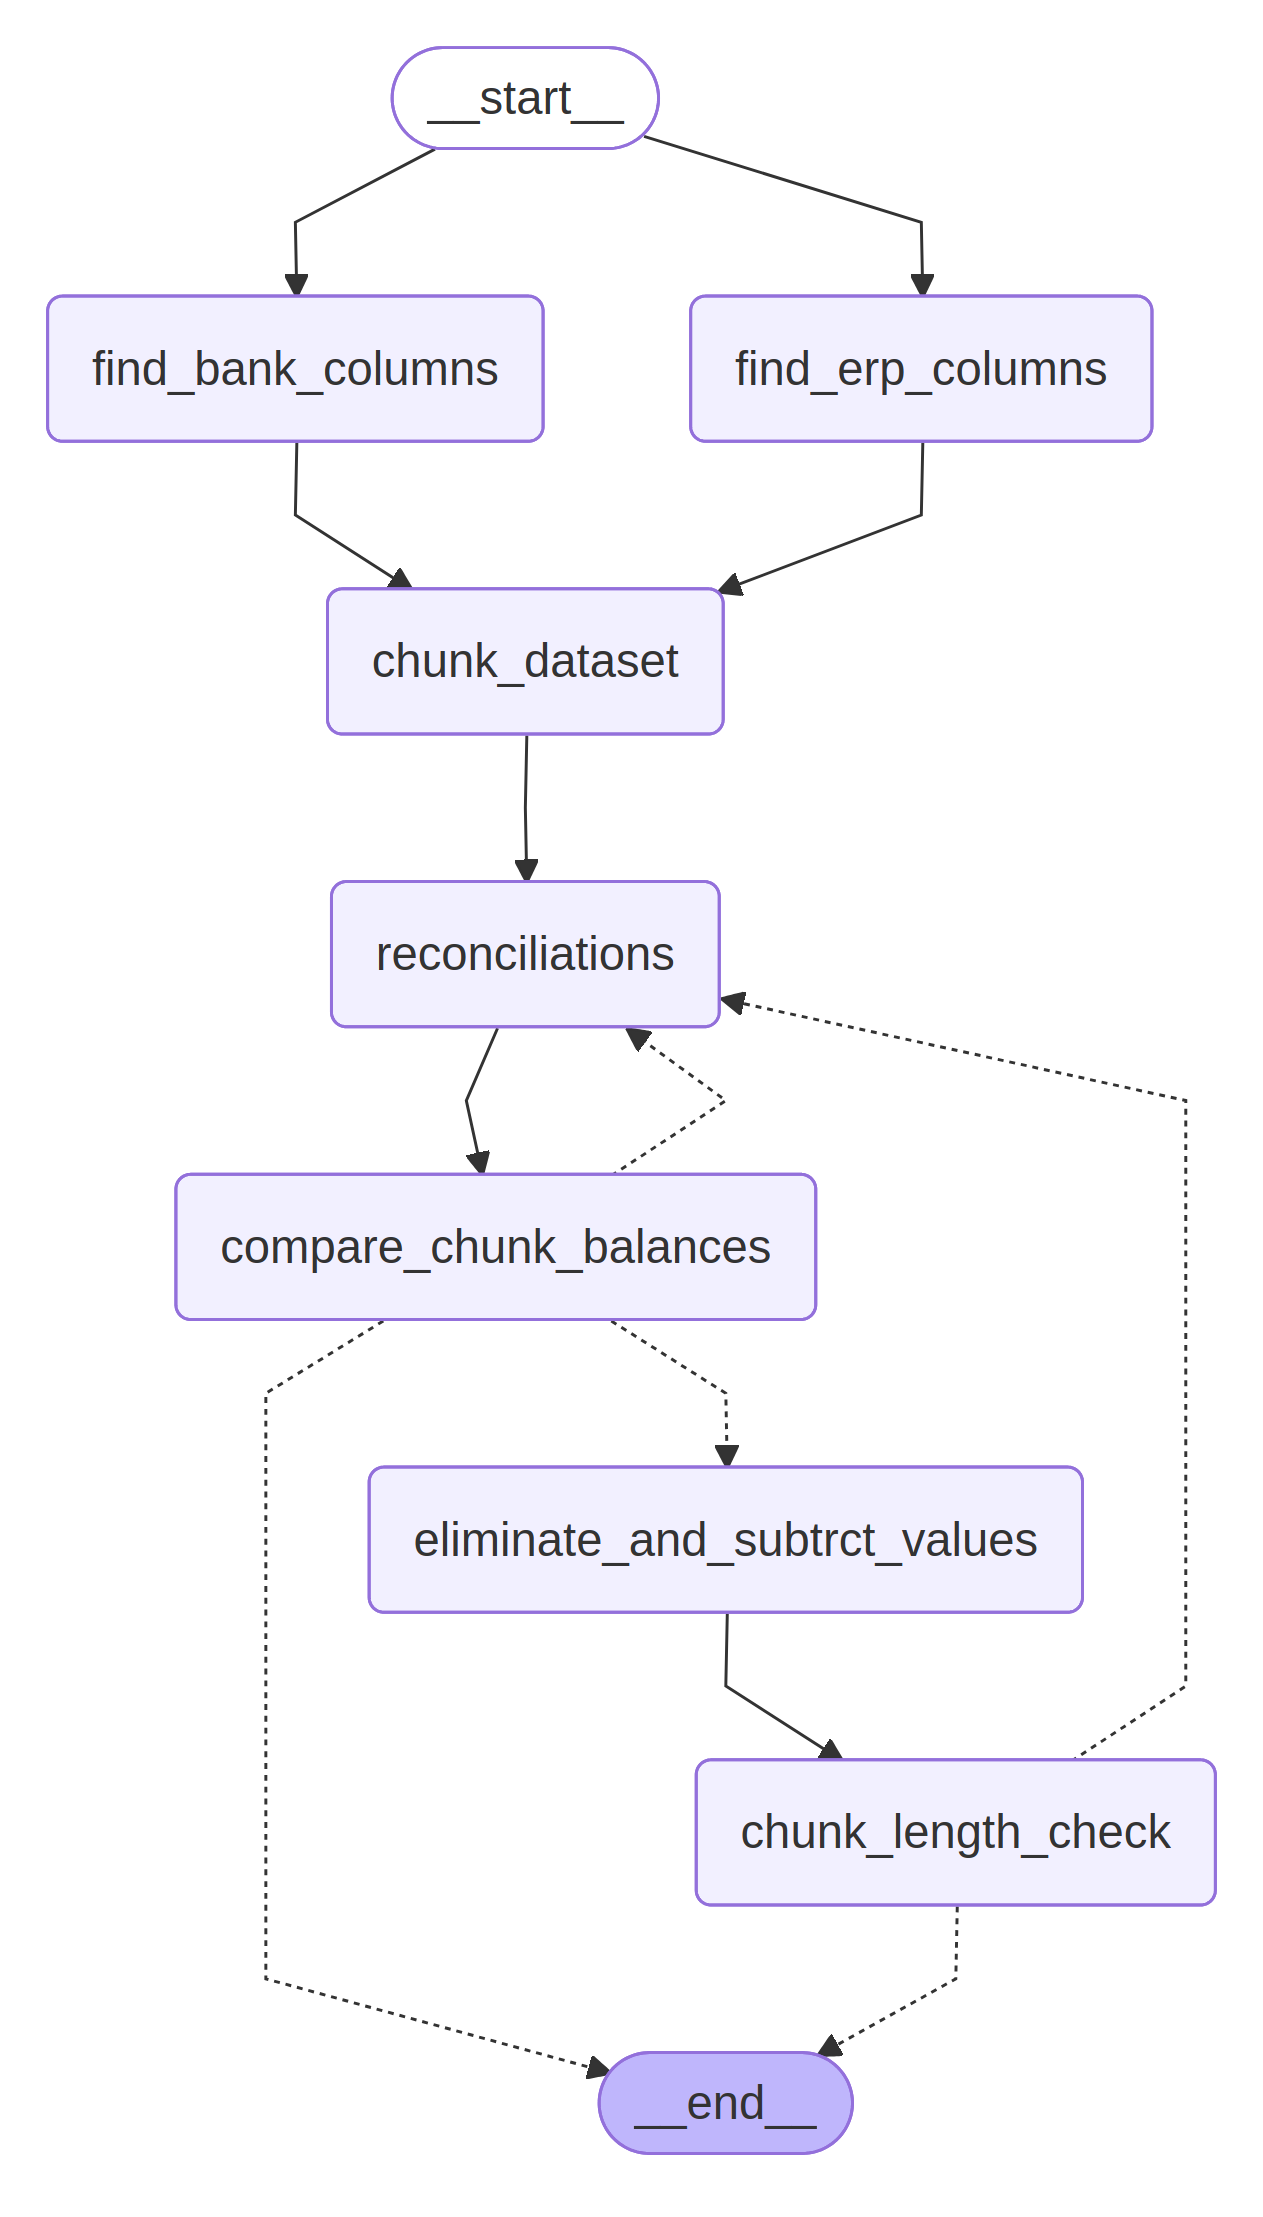

In [17]:
# from IPython.display import Image, display
# Image(workflow.get_graph().draw_mermaid_png())


import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()  # patch the running event loop

# Render workflow graph locally
png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))


In [18]:
# initial_state = {
#     "erp_data": "Dataset/Pubali # 41774-ERP.csv",
#     "bank_data": "Dataset/Pubali # 41774.csv"
# }

# initial_state = {
#     "erp_data": "erp.csv",
#     "bank_data": "bank.csv"
# }

initial_state = {
    "erp_data": "cash_book.csv",
    "bank_data": "bank_statement.csv"
}

try:
    result = workflow.invoke(initial_state, {"recursion_limit": 100})
    print("✅ Workflow executed successfully")
    print(result)
except Exception as e:
    print(f"❌ Error running workflow: {e}")
    import traceback
    traceback.print_exc()


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
/tmp/ipykernel_271168/1458111583.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_df[bank_date_column] = pd.to_datetime(bank_df[bank_date_column], errors="coerce")
/tmp/ipykernel_271168/1458111583.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  erp_df[erp_date_column] = pd.to_datetime(erp_df[erp_date_column], errors="coerce")


transaction_date='Date' debit='Debit (Withdrawals)' credit='Credit (Deposits)'
transaction_date='Date' debit='Debit (Receipts)' credit='Credit (Payments)'
================================:  0


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


💰 LLM Calculated - Bank total: 30000, ERP total: 30000
Bank_total_amount:  30000.0 
 Erp_total_amount:  30000.0
================================:  1


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


💰 LLM Calculated - Bank total: -8500, ERP total: -8500
Bank_total_amount:  21500.0 
 Erp_total_amount:  21500.0
================================:  2


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


💰 LLM Calculated - Bank total: 800, ERP total: 500
✅ Updated balances:
ERP: 500.0 
Bank: 800.0
Bank_total_amount:  22800.0 
 Erp_total_amount:  22800.0
3
✅ Workflow executed successfully
{'bank_data': 'bank_statement.csv', 'erp_data': 'cash_book.csv', 'bank_columns': ColumnSchema(transaction_date='Date', debit='Debit (Withdrawals)', credit='Credit (Deposits)'), 'erp_columns': ColumnSchema(transaction_date='Date', debit='Debit (Receipts)', credit='Credit (Payments)'), 'bank_chunk_data': [        Date  Debit (Withdrawals)  Credit (Deposits)
0 2025-08-01                    0              20000
1 2025-08-02                    0              10000,         Date  Debit (Withdrawals)  Credit (Deposits)
0 2025-08-03                 5000                  0
1 2025-08-04                 3500                  0,         Date  Debit (Withdrawals)  Credit (Deposits)
0 2025-08-05                  200                  0
1 2025-08-06                    0               1000], 'erp_chunk_data': [        

In [19]:
len(result["bank_chunk_data"])

3

In [20]:
index = 15
print(result["bank_chunk_data"][index], "\n\n\n", result["erp_chunk_data"][index])

IndexError: list index out of range

In [ ]:
index = 15
print(result["bank_chunk_data"][index], "\n\n\n", result["erp_chunk_data"][index])

In [ ]:
index = 15
print("Bank: \n", result["bank_chunk_data"][index], "\n\n\n", "Erp: \n", result["erp_chunk_data"][index])

In [ ]:
index = 3
print(result["bank_chunk_data"][index], "\n\n\n", result["erp_chunk_data"][index])

In [ ]:
index = 4
print(result["bank_chunk_data"][index], "\n\n\n", result["erp_chunk_data"][index])

In [ ]:
index = 5
print(result["bank_chunk_data"][index], "\n\n\n", result["erp_chunk_data"][index])

In [ ]:
index = 6
print(result["bank_chunk_data"][index], "\n\n\n", result["erp_chunk_data"][index])

In [ ]:
3850+150-75

In [ ]:
3850-75+150